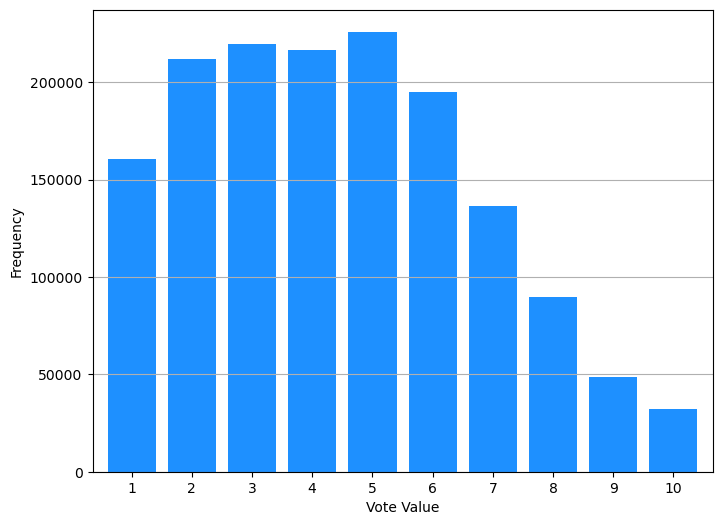

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the .tsv file
file_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'  # Replace with your actual file path
df = pd.read_csv(file_path, sep='\t')

# Split the 'Votes' column and explode it into separate rows
df['Votes'] = df['Votes'].str.split(',')
df_votes = df.explode('Votes')

# Convert 'Votes' column to integer type
df_votes['Votes'] = df_votes['Votes'].astype(int)

# Display the distribution of votes
vote_counts = df_votes['Votes'].value_counts().sort_index()

# Plot the histogram of raw "Votes" feature
plt.figure(figsize=(8, 6))
vote_counts.plot(kind='bar', color='#1E90FF', width=0.8)  

plt.xlabel('Vote Value')
plt.ylabel('Frequency')
# plt.title('Distribution of Votes')
plt.xticks(rotation=0)

plt.grid(axis='y')

plt.show()


/tmp/ipykernel_649921/665887717.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)


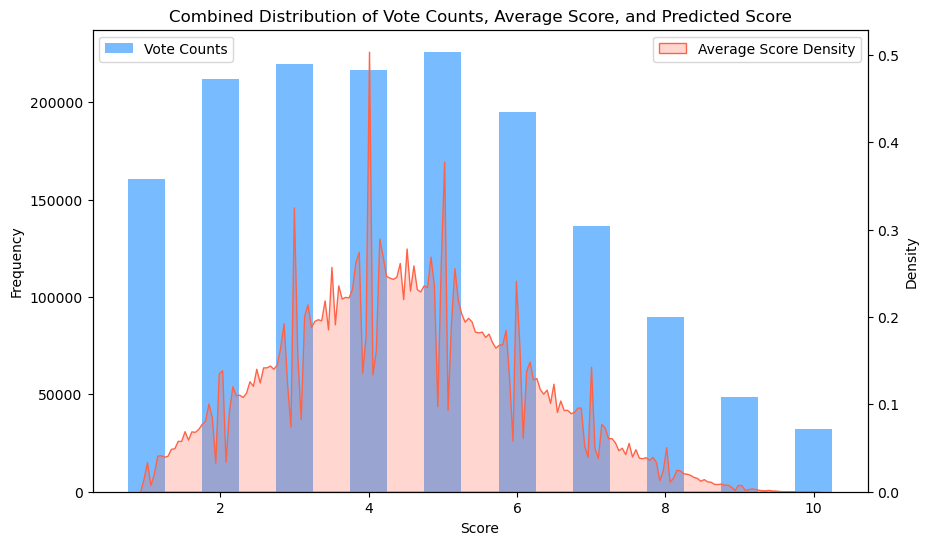

Predicted Score Data Sample:
Series([], Name: predicted_score, dtype: object)
Predicted Score Data Description:
count       0
unique      0
top       NaN
freq      NaN
Name: predicted_score, dtype: object


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

# 读取第一组数据
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'  
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
vote_counts = df_votes['Votes'].value_counts().sort_index()

# 第二组数据
average_data = df_votes['Average']

# 第三组数据
project_base_path = Path.cwd().parent
directory_path = project_base_path / 'data' / 'processed' / 'landscape_score'

scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].tolist())

scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# 开始绘图
plt.figure(figsize=(10, 6))

# 创建双坐标轴
ax1 = plt.gca()
ax2 = ax1.twinx()

# 绘制 Vote Counts 的条形图在 ax1 上
ax1.bar(vote_counts.index, vote_counts.values, color='#1E90FF', alpha=0.6, width=0.5, label="Vote Counts")

# 绘制 Average Score Density 在 ax2 上
sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)

# 绘制 Predicted Score Density 在 ax2 上
sns.histplot(scores_df['predicted_score'], bins=50, kde=True, color="#32CD32", stat="density", label="Predicted Score Density", ax=ax2)

# 设置标签和标题
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Density')
plt.title('Combined Distribution of Vote Counts, Average Score, and Predicted Score')

# 设置图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

print("Predicted Score Data Sample:")
print(scores_df['predicted_score'].head())
print("Predicted Score Data Description:")
print(scores_df['predicted_score'].describe())



/tmp/ipykernel_649921/4287430435.py:42: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)
/tmp/ipykernel_649921/4287430435.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_df['predicted_score'], shade=True, color="#32CD32", bw_adjust=0.3, label="Predicted Score Density", ax=ax2)


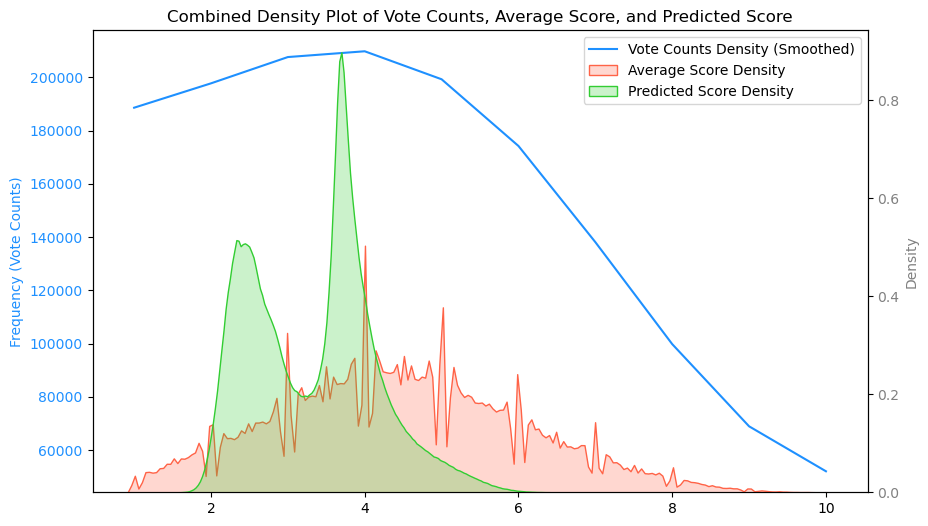

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.ndimage import gaussian_filter1d

# 设置数据文件路径
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# 读取 Vote Counts 和 Average 数据
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
average_data = df_votes['Average']  # 假设 'Average' 列已存在于第一个文件中

# 计算 Vote Counts 的频数分布并进行高斯平滑
vote_counts_data = df_votes['Votes'].value_counts().sort_index()
vote_counts_smoothed = gaussian_filter1d(vote_counts_data.values, sigma=1.5)  # 使用 sigma 进行平滑

# 读取 predicted_score 数据
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist())  # 使用 dropna() 去除空值
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# 开始绘制图表
plt.figure(figsize=(10, 6))

# 主坐标轴绘制平滑后的 Vote Counts 曲线
ax1 = plt.gca()
ax1.plot(vote_counts_data.index, vote_counts_smoothed, color="#1E90FF", label="Vote Counts Density (Smoothed)")
ax1.set_ylabel('Frequency (Vote Counts)', color="#1E90FF")
ax1.tick_params(axis='y', labelcolor="#1E90FF")

# 次坐标轴绘制 Average Score 和 Predicted Score 的密度曲线
ax2 = ax1.twinx()
sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)
sns.kdeplot(scores_df['predicted_score'], shade=True, color="#32CD32", bw_adjust=0.3, label="Predicted Score Density", ax=ax2)
ax2.set_ylabel('Density', color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# 设置图表的标签和标题
plt.xlabel('Score')
plt.title('Combined Density Plot of Vote Counts, Average Score, and Predicted Score')

# 设置图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 显示图表
plt.show()


/tmp/ipykernel_649921/3373187244.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Average'], shade=True, color='#1E90FF', bw_adjust=0.3)


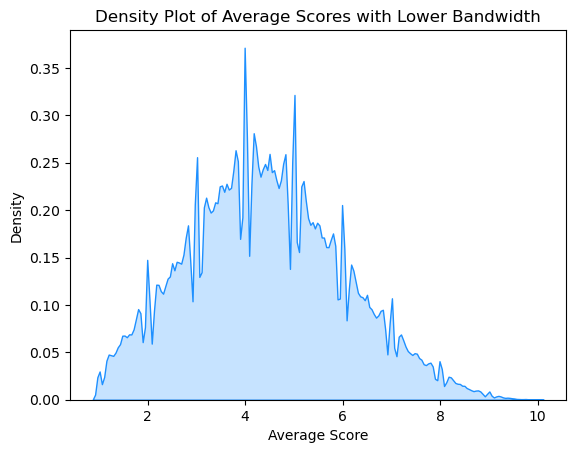

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

file_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'  # Replace with your actual file path
df = pd.read_csv(file_path, sep='\t')

average_data = df['Average']

sns.kdeplot(df['Average'], shade=True, color='#1E90FF', bw_adjust=0.3) 
plt.xlabel('Average Score')
plt.ylabel('Density')
plt.title('Density Plot of Average Scores with Lower Bandwidth')
plt.show()


/tmp/ipykernel_649921/603194584.py:47: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)


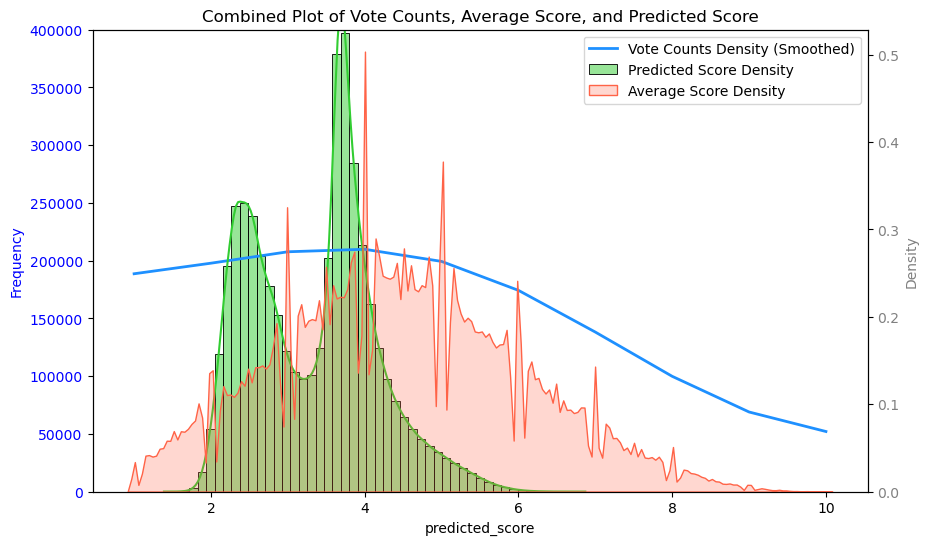

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.ndimage import gaussian_filter1d

# 设置数据文件路径
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# 读取 votes 数据
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
vote_counts = df_votes['Votes'].value_counts().sort_index()  # 统计频率
average_data = df_votes['Average']  # 假设 'Average' 列已存在于该文件中

# 对 votes 的频数分布数据进行高斯平滑
vote_counts_smoothed = gaussian_filter1d(vote_counts.values, sigma=1.5)

# 读取 predicted_score 数据
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist())  # 去除空值
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# 开始绘制图表
plt.figure(figsize=(10, 6))

# 主坐标轴：绘制 Vote Counts 的频率分布
ax1 = plt.gca()
ax1.plot(vote_counts.index, vote_counts_smoothed, color="#1E90FF", label="Vote Counts Density (Smoothed)", linewidth=2)
ax1.set_ylabel('Frequency', color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_ylim(0, 400000)  # 设置左侧 y 轴范围适应最大频率值

# 使用 sns.histplot 显示 Predicted Score 的直方图和密度曲线（双峰）
sns.histplot(scores_df['predicted_score'], bins=50, kde=True, color="#32CD32", label="Predicted Score Density", ax=ax1)
# Note: histplot automatically detects peaks in data for KDE when kde=True

# 次坐标轴：绘制 Average Score 的密度分布
ax2 = ax1.twinx()
sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)
ax2.set_ylabel('Density', color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# 设置 x 轴标签和标题
plt.xlabel('Score')
plt.title('Combined Plot of Vote Counts, Average Score, and Predicted Score')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 显示图表
plt.show()


/tmp/ipykernel_649921/3650419077.py:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)


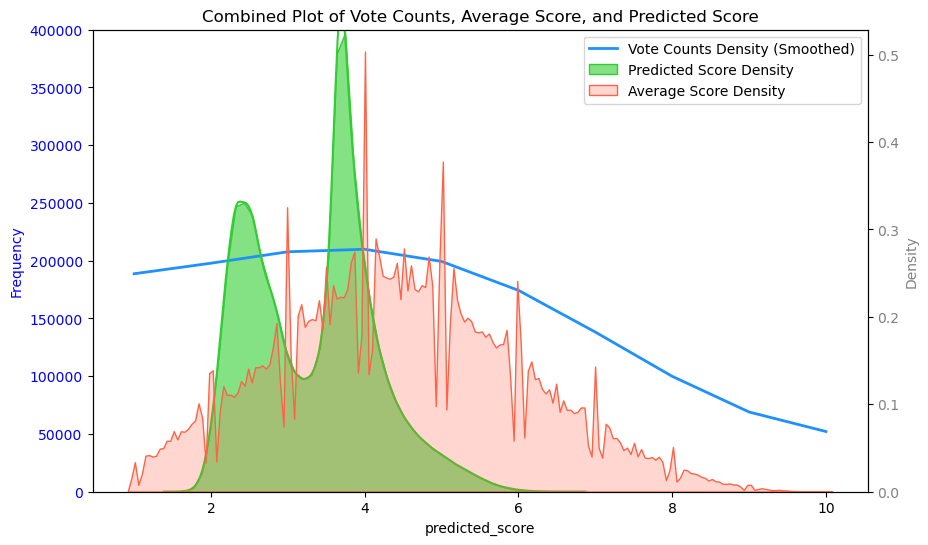

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.ndimage import gaussian_filter1d

# 设置数据文件路径
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# 读取 votes 数据
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
vote_counts = df_votes['Votes'].value_counts().sort_index()  # 统计频率
average_data = df_votes['Average']  # 假设 'Average' 列已存在于该文件中

# 对 votes 的频数分布数据进行高斯平滑
vote_counts_smoothed = gaussian_filter1d(vote_counts.values, sigma=1.5)

# 读取 predicted_score 数据
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist())  # 去除空值
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# 开始绘制图表
plt.figure(figsize=(10, 6))

# 主坐标轴：绘制 Vote Counts 的频率分布
ax1 = plt.gca()
ax1.plot(vote_counts.index, vote_counts_smoothed, color="#1E90FF", label="Vote Counts Density (Smoothed)", linewidth=2)
ax1.set_ylabel('Frequency', color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_ylim(0, 400000)  # 设置左侧 y 轴范围适应最大频率值

# 使用 sns.histplot 显示 Predicted Score 的双峰分布（去除边框）
sns.histplot(scores_df['predicted_score'], bins=50, kde=True, color="#32CD32", label="Predicted Score Density", ax=ax1, element="poly", alpha=0.6)

# 次坐标轴：绘制 Average Score 的密度分布
ax2 = ax1.twinx()
sns.kdeplot(average_data, shade=True, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)
ax2.set_ylabel('Density', color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# 设置 x 轴标签和标题
plt.xlabel('Score')
plt.title('Combined Plot of Vote Counts, Average Score, and Predicted Score')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 显示图表
plt.show()


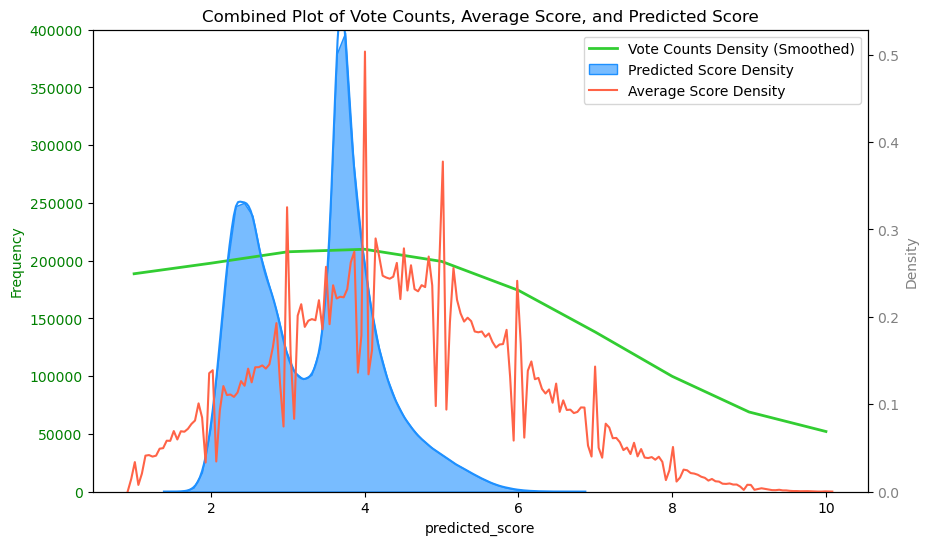

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.ndimage import gaussian_filter1d

# 设置数据文件路径
file_path_1 = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/votes.tsv'
directory_path = Path('/home/ubuntu/landscape-aesthetics/data/processed/landscape_score')

# 读取 votes 数据
df_votes = pd.read_csv(file_path_1, sep='\t')
df_votes['Votes'] = df_votes['Votes'].str.split(',')
df_votes = df_votes.explode('Votes')
df_votes['Votes'] = df_votes['Votes'].astype(int)
vote_counts = df_votes['Votes'].value_counts().sort_index()  # 统计频率
average_data = df_votes['Average']  # 假设 'Average' 列已存在于该文件中

# 对 votes 的频数分布数据进行高斯平滑
vote_counts_smoothed = gaussian_filter1d(vote_counts.values, sigma=1.5)

# 读取 predicted_score 数据
scores = []
for file in glob.glob(str(directory_path / "*.csv")):
    df = pd.read_csv(file)
    if 'predicted_score' in df.columns:
        scores.extend(df['predicted_score'].dropna().tolist())  # 去除空值
scores_df = pd.DataFrame(scores, columns=['predicted_score'])

# 开始绘制图表
plt.figure(figsize=(10, 6))

# 主坐标轴：绘制 Vote Counts 的频率分布，颜色设为绿色
ax1 = plt.gca()
ax1.plot(vote_counts.index, vote_counts_smoothed, color="#32CD32", label="Vote Counts Density (Smoothed)", linewidth=2)
ax1.set_ylabel('Frequency', color="green")
ax1.tick_params(axis='y', labelcolor="green")
ax1.set_ylim(0, 400000)  # 设置左侧 y 轴范围适应最大频率值

# 使用 sns.histplot 显示 Predicted Score 的双峰分布，颜色设为蓝色
sns.histplot(scores_df['predicted_score'], bins=50, kde=True, color="#1E90FF", label="Predicted Score Density", ax=ax1, element="poly", alpha=0.6)

# 次坐标轴：绘制 Average Score 的密度分布（无阴影填充，颜色设为红色）
ax2 = ax1.twinx()
sns.kdeplot(average_data, color="#FF6347", bw_adjust=0.3, label="Average Score Density", ax=ax2)  # 去掉 shade 参数
ax2.set_ylabel('Density', color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# 设置 x 轴标签和标题
plt.xlabel('Score')
plt.title('Combined Plot of Vote Counts, Average Score, and Predicted Score')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 显示图表
plt.show()
